In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes,remove_small_objects,binary_closing,closing,convex_hull_image
from skimage.morphology import skeletonize, thin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE 
import pandas as pd
import seaborn as sns
import os
from collections import Counter

In [2]:
def count_single_bacillus(cnt):
    sing_tb_count = 0
    cnt_approx = cv2.approxPolyDP(cnt,0.005*cv2.arcLength(cnt, True),True)
    hull = cv2.convexHull(cnt_approx, returnPoints=False)
    hull[::-1].sort(axis=0)
    defects = cv2.convexityDefects(cnt_approx, hull)
    if (defects is not None and defects.shape[0]>1):
        st_ind = -1
        #st_ind = 0
        for j in range(st_ind,defects.shape[0]-1):
            ind1 = defects[j,0,2]
            ind2 = defects[j+1,0,2]
            #print(ind1,ind2)
            if (ind1>ind2):
                list1 = list(range(ind1,cnt_approx.shape[0]))
                list2 = list(range(0,ind2+1))
                list_ = list1+list2
                #print(list_)
                cnt_temp1 = cnt_approx[list_]
            else:
                cnt_temp1 = cnt_approx[ind1:ind2+1]
            #print(cnt_temp1)
            img_temp = np.zeros(img_shape, np.uint8)
            img_temp = cv2.drawContours(img_temp, [cnt_temp1], -1, 255, 3)
            contours_temp,_ = cv2.findContours(img_temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnt_temp2 = contours_temp[0]
            
            if (len(cnt_temp2)>=5):
                (x,y),(ma,MA),angle = cv2.fitEllipse(cnt_temp2)
                eccentricity = ma/MA
                area = cv2.contourArea(cnt_temp2)
                #print((eccentricity,area))
                if (eccentricity>0.1 and eccentricity<0.7 and area>50):
                    sing_tb_count+=1
                    
    return sing_tb_count,defects    

In [3]:
# Function definition to find contours of objects present on the post processed labelled image

def find_contours(img_pp_lbl):
    contours,_ = cv2.findContours(img_pp_lbl, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area_th = 2000
    contours_filt = []
    for cnt in contours:
        if (len(cnt)<5):
            continue
        (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
        area = cv2.contourArea(cnt)
        area_ell = np.pi*ma*MA/4
        if (x>img_shape[1] or x<0 or y>img_shape[0] or y<0 or area<5 or area>area_th):
            continue
        contours_filt.append(cnt)
        
    return contours_filt      

In [4]:
# Function definition to calculate geometric features of a contour

def extract_features(cnt):
    (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
    cnt_centre = (int(x),int(y))
    eccentricity = ma/MA
    perimeter = cv2.arcLength(cnt,True)
    area = cv2.contourArea(cnt)
    hull = cv2.convexHull(cnt)
    perimeter_hull = cv2.arcLength(hull,True)
    roughness = perimeter/perimeter_hull
    area_hull = cv2.contourArea(hull)
    rel_conv_area = area_hull/area
    circularity = (4*np.pi*area)/perimeter**2
    compactness = perimeter**2/(4*np.pi*area)
    area_um = area*2.2
    x,y,w,h = cv2.boundingRect(cnt)
    asp_ratio = w/h

    features = (cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity)
    
    return features

In [5]:
# Function definition of image segmentation to separate the potential bacilli objects from image background

def image_segmentation(img):
    
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_cr = img_ycrcb[:,:,1]       
    cr_hist,_ = np.histogram(img_cr.ravel(),256,[0,256])
    cr_hist_diff = np.diff(cr_hist)

    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_a = img_lab[:,:,1]
    a_hist,_ = np.histogram(img_a.ravel(),256,[0,256])
    a_hist_diff = np.diff(a_hist)
    
    int_lvls = np.arange(0,255)
    
    cr_hist_th = int(-18000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[cr_hist_diff<=cr_hist_th].size!=0):
        cr_th_i = np.max(int_lvls[cr_hist_diff<=cr_hist_th])
    else:
        cr_th_i = np.argmax(cr_hist)

    a_hist_th = int(-1000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[a_hist_diff<=a_hist_th].size!=0):
        a_th_i = np.max(int_lvls[a_hist_diff<=a_hist_th])
    else:
        a_th_i = np.argmax(a_hist)

    
    a_th = a_th_i
    cr_th = cr_th_i
    _, img_a_th = cv2.threshold(img_a, a_th, 255, cv2.THRESH_BINARY)
    _, img_cr_th = cv2.threshold(img_cr, cr_th, 255, cv2.THRESH_BINARY)
    
    img_seg = cv2.bitwise_and(img_cr_th,img_a_th)

    return img_seg

In [6]:
# Function definition of image postprocessing to remove small size artifacts from segmented image

def image_postprocess(img_seg):
    
    # Removing small size artifacts on segmented image
    img_bin1 = (img_seg//255).astype(bool)
    img_rem1 = remove_small_objects(img_bin1,min_size=20,connectivity=8).astype('uint8')*255
    #img_fill = (remove_small_holes(img_rem1,area_threshold=5000,connectivity=8)).astype('uint8')*255
    #img_bin2 = (img_fill//255).astype(bool)
    #img_rem2 = remove_small_objects(img_bin2,min_size=50,connectivity=8).astype('uint8')*255
    img_pp = img_rem1.copy()
    
    return img_pp

In [7]:
# Function definition to assign class label to each image object

def label_image_objects(img_file,annot_fold_path):

    annot_file = img_file[:-4]+'_annot.csv'
    annot_file_path = os.path.join(annot_fold_path,annot_file)

    annot_cols = ["Label","x_st_pt","y_st_pt","box_width","box_height","Image_name","Image_width","Image_height"]

    lbl_data = pd.read_csv(annot_file_path,names=annot_cols, header=0)
    
    img_lbl = np.ones(orig_img_shape[:2], np.uint8)*20

    for i in range(lbl_data.shape[0]):
        x_st_pt = lbl_data["x_st_pt"][i]
        y_st_pt = lbl_data["y_st_pt"][i]
        x_end_pt = x_st_pt+lbl_data["box_width"][i]
        y_end_pt = y_st_pt+lbl_data["box_height"][i]
        if (lbl_data["Label"][i]=="single bacillus"):
            fill_val = 50
        if (lbl_data["Label"][i]=="bacilli cluster"):
            fill_val = 100
        if (lbl_data["Label"][i]=="unclassified red structures"):
            fill_val = 150
        if (lbl_data["Label"][i]=="artifacts"):
            fill_val = 200
        st_pt = (x_st_pt,y_st_pt)
        end_pt = (x_end_pt,y_end_pt)
        cv2.rectangle(img_lbl, st_pt, end_pt, fill_val, thickness=-1)
    
    img_lbl = cv2.resize(img_lbl,(img_shape[1],img_shape[0]))

    img_pp_lbl = cv2.bitwise_and(img_pp,img_lbl)
    
    return img_lbl,img_pp_lbl

In [8]:
# Function definition to get class label of the contour based on pixel intensity

def get_class_lbl(img_lbl,cnt_centre):
    if (img_lbl[cnt_centre[1],cnt_centre[0]]==50):
        cls_lbl = "1"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==100):
        cls_lbl = "2"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==20):
        cls_lbl = "3"
    else:
        cls_lbl = None
    
    return cls_lbl

# Training

In [9]:
# Initialization of empty pandas data frame with below columns to store data matrix

cols_data = ['Area', 'Roughness','Relative convex area','Circularity','Compactness','Eccentricity','Class']
data = pd.DataFrame(columns = cols_data)

In [10]:
# Main Folder consisting of image data
main_fold = r"C:\Users\JEEVANANTHAM\Downloads\bacilli_count\code\baci-count\data\train-test"

# Image subfolders
# folders = ["Mannual_Microscope-2_set1","Mannual_Microscope-2_set2","Mannual_Seg_Microscope-1_set6","Mannual_Seg_Microscope-1_set7"]
folders = ["Mannual_Microscope-2_set1"]

In [11]:
import cv2
import os
import pandas as pd

img_shape = (600, 800)

data_list = []

for folder in folders:
    fold_path = os.path.join(main_fold, folder)
    img_fold_path = os.path.join(fold_path, "Images")
    annot_fold_path = os.path.join(fold_path, "Annotations")
    img_files = os.listdir(img_fold_path)

    for img_file in img_files:
        img_file_path = os.path.join(img_fold_path, img_file)
        orig_img = cv2.imread(img_file_path)
        
        if orig_img is None:
            print(f"Warning: Unable to read image {img_file_path}")
            continue
        orig_img_shape = orig_img.shape[0:2]
        img = orig_img.copy()
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img_th = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY_INV)
        img_th_inv = 255 - img_th
        
        img_seg = image_segmentation(img)
        
        img_seg = cv2.bitwise_and(img_seg, img_th_inv)
        
        img_seg = cv2.resize(img_seg, (img_shape[1], img_shape[0]))

        img_pp = image_postprocess(img_seg)
        
        img_lbl, img_pp_lbl = label_image_objects(img_file, annot_fold_path)
        
        contours_filt = find_contours(img_pp_lbl)
        
        for cnt in contours_filt:
            features = extract_features(cnt)
            cnt_centre, area, roughness, rel_conv_area, eccentricity, circularity, compactness, _ = features
            cls_lbl = get_class_lbl(img_lbl, cnt_centre)
            
            if cls_lbl:
                data_list.append({
                    'Area': area,
                    'Roughness': roughness,
                    'Relative convex area': rel_conv_area,
                    'Circularity': circularity,
                    'Compactness': compactness,
                    'Eccentricity': eccentricity,
                    'Class': cls_lbl
                })

data = pd.DataFrame(data_list)

data.to_csv('output.csv', index=False)


In [12]:
import pandas as pd

cols_data = ['Area', 'Relative convex area', 'Circularity', 'Compactness', 'Eccentricity', 'Class']  # Adjust as necessary

types = data["Class"].unique()
d = {type: data[data['Class'] == type] for type in types}
d_new = {}
data_filt = pd.DataFrame(columns=cols_data)

for type in types:
    df_temp = d[type]
    
    numeric_cols = df_temp.select_dtypes(include=['number']).columns
    df_temp_numeric = df_temp[numeric_cols]
    
    Q1 = df_temp_numeric.quantile(0.25)
    Q3 = df_temp_numeric.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    
    mask = ((df_temp_numeric >= lower_lim) & (df_temp_numeric <= upper_lim)).all(axis=1)
    
    df_temp_filtered = df_temp[mask]
    
    d_new[type] = df_temp_filtered
    
    data_filt = pd.concat([data_filt, d_new[type]])

if 'Roughness' in data_filt.columns:
    data_filt.drop(['Roughness'], axis=1, inplace=True)

print(data_filt.shape)
data_filt.head()


(415, 6)


C:\Users\JEEVANANTHAM\AppData\Local\Temp\ipykernel_824\2622577273.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_filt = pd.concat([data_filt, d_new[type]])


,Area,Relative convex area,Circularity,Compactness,Eccentricity,Class
0,15.5,1.000000,0.738292,1.354477,0.599371,3
3,12.0,1.291667,0.441305,2.266006,0.469173,3
6,28.5,1.245614,0.501331,1.994691,0.451781,3
7,29.5,1.288136,0.464752,2.151685,0.920482,3
8,13.5,1.629630,0.353733,2.826992,0.493015,3


<Axes: >

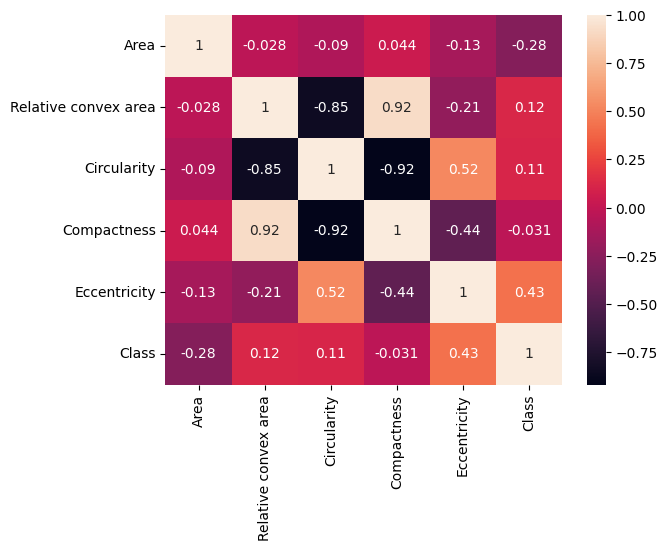

In [13]:
data_corr = data_filt.corr()
sns.heatmap(data_corr,annot=True)

In [14]:
rows_cf = ["Actual class-1","Actual class-2","Actual class-3"]
cols_cf = ["Predicted class-1","Predicted class-2","Predicted class-3"]

In [15]:
X = data_filt.iloc[:,:-1]

y = data_filt.iloc[:,-1]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_before = Counter(y_train_val)
print(count_before)
X_train_val, y_train_val = SMOTE().fit_resample(X_train_val, y_train_val)
count_after = Counter(y_train_val)
print(count_after)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

Counter({'3': 282, '1': 44, '2': 6})
Counter({'3': 282, '1': 282, '2': 282})


In [16]:

dt = DecisionTreeClassifier(max_depth=9,min_impurity_decrease=0.0).fit(X_train,y_train)
y_pred_train = dt.predict(X_train)
y_pred_val = dt.predict(X_val)
y_pred_test = dt.predict(X_test)


print("Classification report (train):\n", classification_report(y_train, y_pred_train))
print("Classification report (validation):\n", classification_report(y_val, y_pred_val))
print("Classification report (test):\n", classification_report(y_test, y_pred_test))
conf_mat_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train),index=rows_cf,columns=cols_cf)
print("Confusion matrix (train):\n",conf_mat_train)
conf_mat_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val),index=rows_cf,columns=cols_cf)
print("Confusion matrix (validation):\n",conf_mat_val)
conf_mat_test = pd.DataFrame(confusion_matrix(y_test,y_pred_test),index=rows_cf,columns=cols_cf)
print("Confusion matrix (test):\n",conf_mat_test)
dt.feature_importances_

Classification report (train):
               precision    recall  f1-score   support

           1       0.92      1.00      0.96       232
           2       1.00      0.99      0.99       222
           3       1.00      0.92      0.96       222

    accuracy                           0.97       676
   macro avg       0.97      0.97      0.97       676
weighted avg       0.97      0.97      0.97       676

Classification report (validation):
               precision    recall  f1-score   support

           1       0.83      1.00      0.91        50
           2       0.95      0.95      0.95        60
           3       0.96      0.80      0.87        60

    accuracy                           0.91       170
   macro avg       0.91      0.92      0.91       170
weighted avg       0.92      0.91      0.91       170

Classification report (test):
               precision    recall  f1-score   support

           1       0.39      0.58      0.47        12
           2       0.33      

array([0.45852554, 0.12666438, 0.05296224, 0.04240835, 0.31943948])

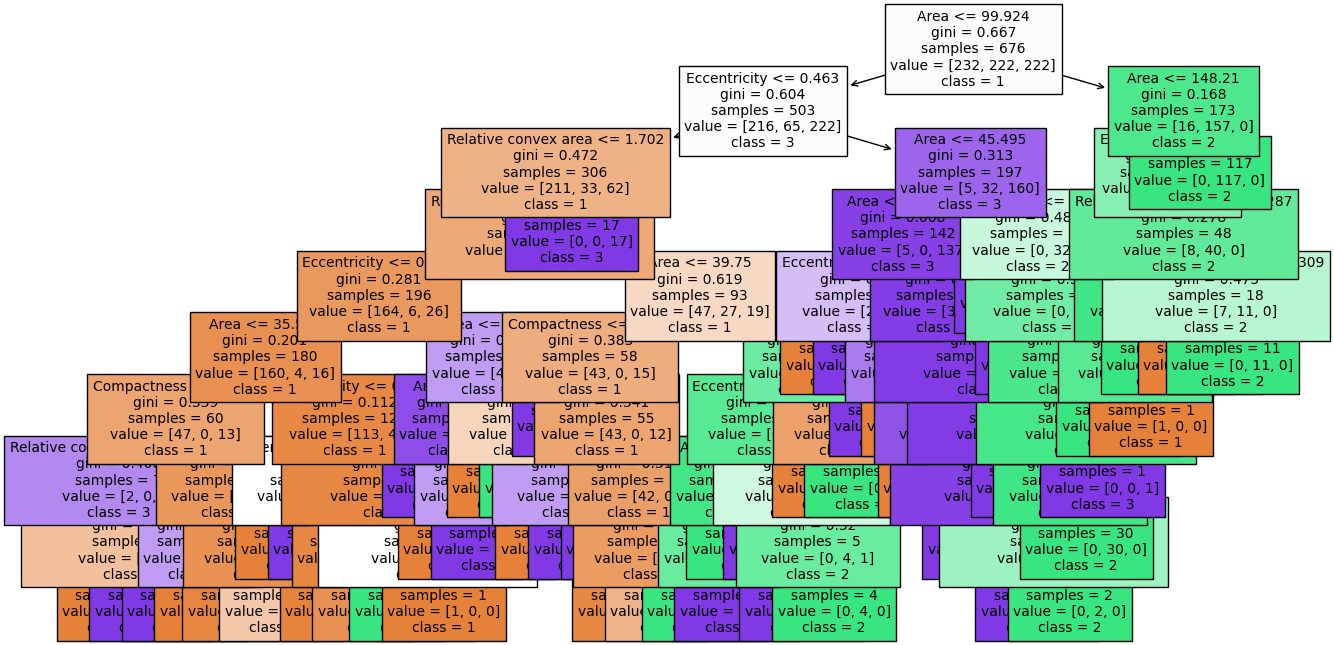

In [17]:
fig,ax = plt.subplots(figsize=(15,8))
plot_tree(dt,feature_names = data_filt.columns[:-1],class_names = ["1","2","3"],filled=True,fontsize=10)
plt.show()

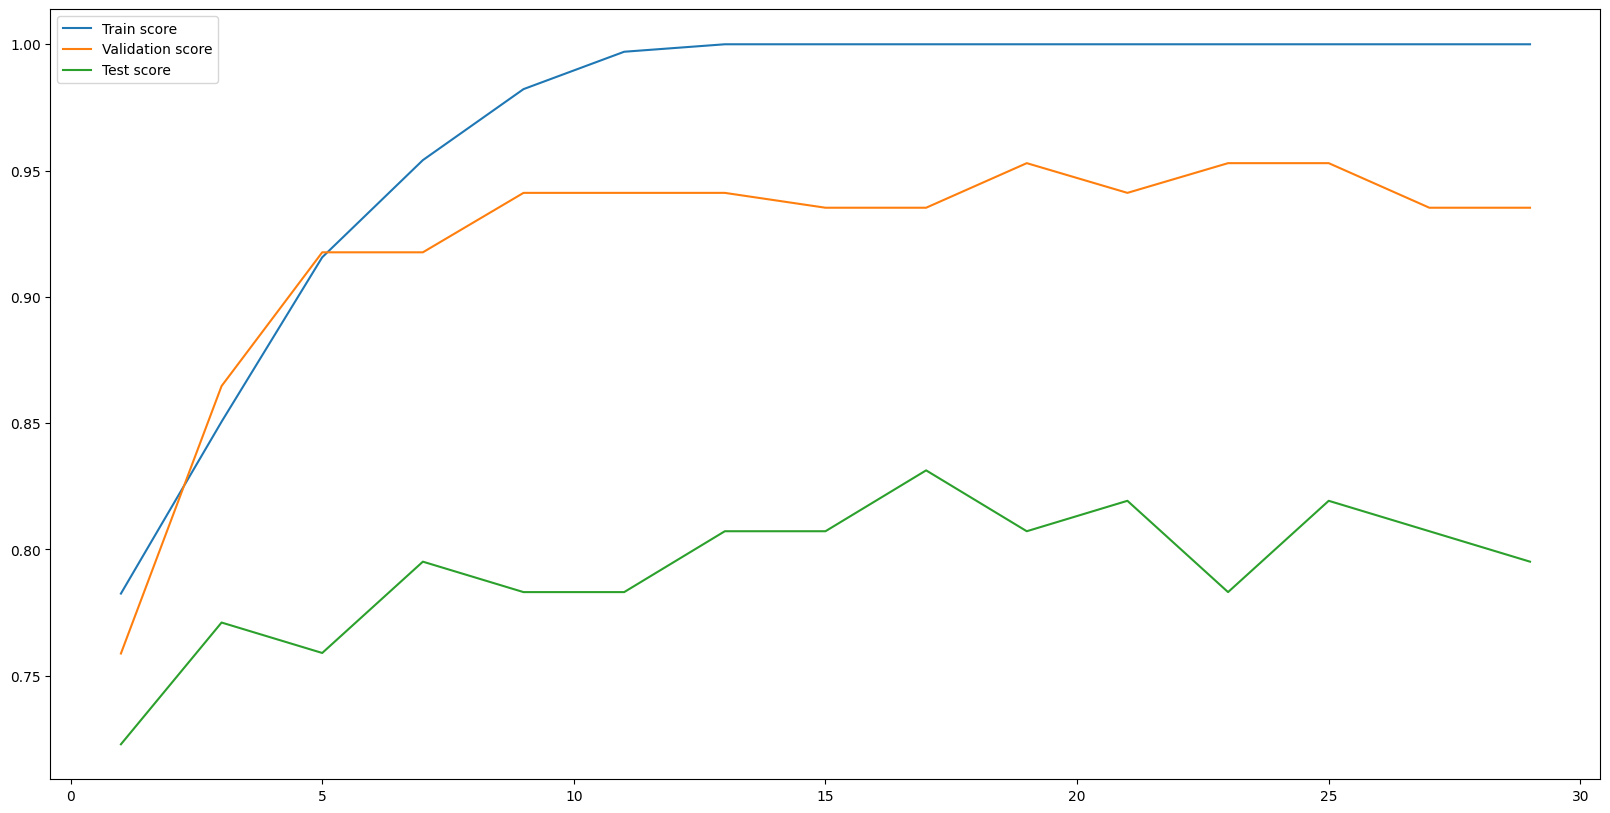

In [18]:
max_depth_list = list(range(1,30,2))

train_scores = []
val_scores = []
test_scores = []

for max_depth in max_depth_list:
    rf_test1 = RandomForestClassifier(max_depth=max_depth).fit(X_train,y_train)
    y_pred_train = rf_test1.predict(X_train)
    y_pred_val = rf_test1.predict(X_val)
    y_pred_test = rf_test1.predict(X_test)
    train_score = f1_score(y_train, y_pred_train,average='micro')
    train_scores.append(train_score)
    val_score = f1_score(y_val, y_pred_val,average='micro')
    val_scores.append(val_score)
    test_score = f1_score(y_test, y_pred_test,average='micro')
    test_scores.append(test_score)
    
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(max_depth_list,train_scores)
ax.plot(max_depth_list,val_scores)
ax.plot(max_depth_list,test_scores)
ax.legend(["Train score", "Validation score", "Test score"])

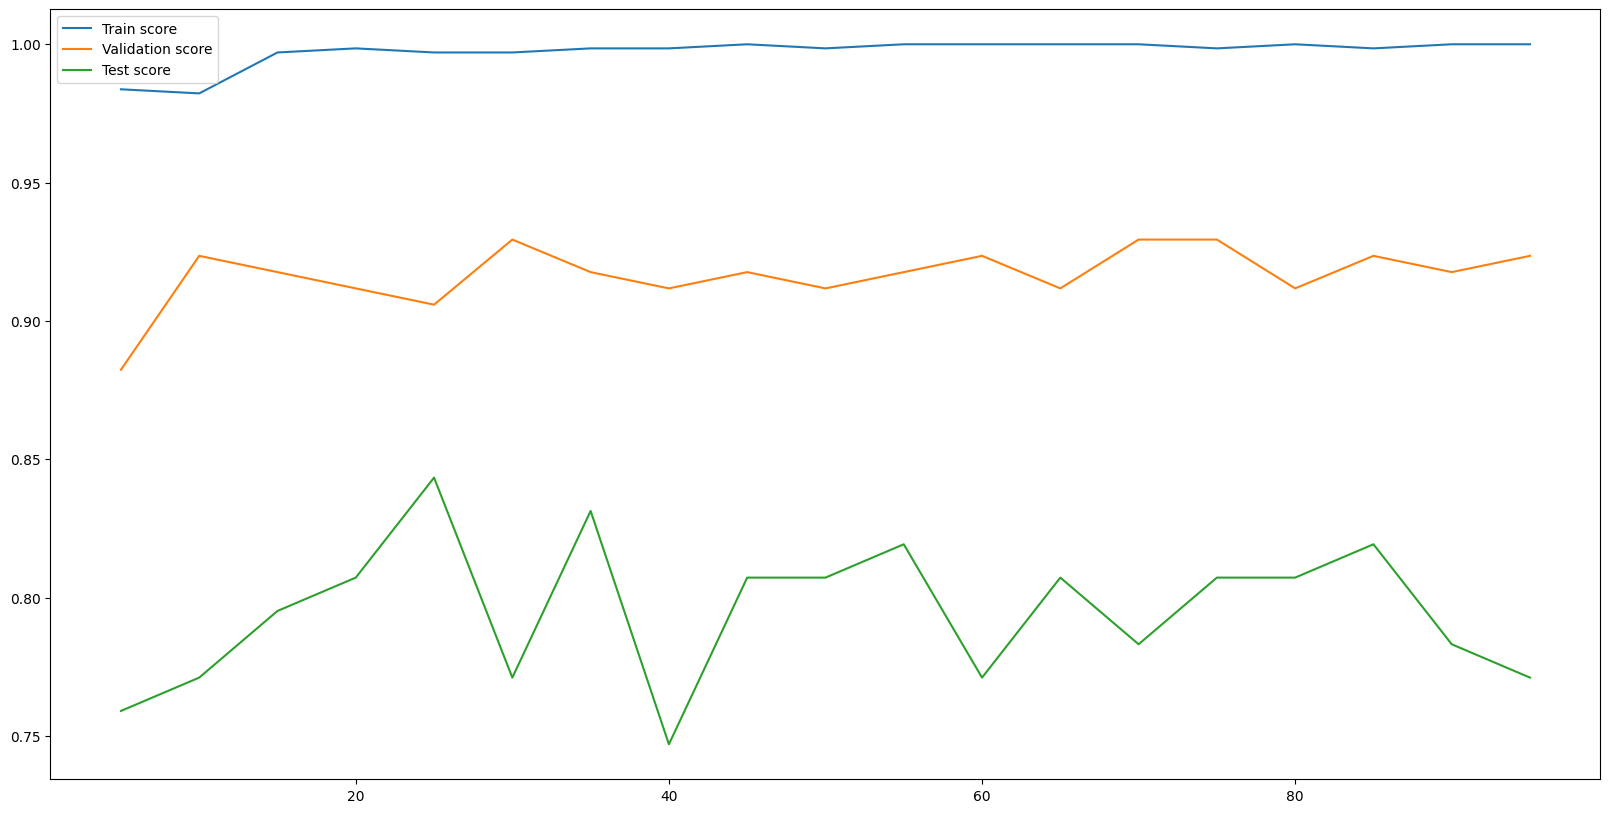

In [19]:
n_estimators_list = list(range(5,100,5))

train_scores = []
val_scores = []
test_scores = []

for n_estimators in n_estimators_list:
    rf_test2 = RandomForestClassifier(n_estimators=n_estimators).fit(X_train,y_train)
    y_pred_train = rf_test2.predict(X_train)
    y_pred_val = rf_test2.predict(X_val)
    y_pred_test = rf_test2.predict(X_test)
    train_score = f1_score(y_train, y_pred_train,average='micro')
    train_scores.append(train_score)
    val_score = f1_score(y_val, y_pred_val,average='micro')
    val_scores.append(val_score)
    test_score = f1_score(y_test, y_pred_test,average='micro')
    test_scores.append(test_score)
    
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(n_estimators_list,train_scores)
ax.plot(n_estimators_list,val_scores)
ax.plot(n_estimators_list,test_scores)
ax.legend(["Train score", "Validation score", "Test score"])

In [19]:
rf = RandomForestClassifier(n_estimators=50,max_depth=9).fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)


print("Classification report (train):\n", classification_report(y_train, y_pred_train))
print("Classification report (validation):\n", classification_report(y_val, y_pred_val))
print("Classification report (test):\n", classification_report(y_test, y_pred_test))
conf_mat_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train),index=rows_cf,columns=cols_cf)
print("Confusion matrix (train):\n",conf_mat_train)
conf_mat_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val),index=rows_cf,columns=cols_cf)
print("Confusion matrix (validation):\n",conf_mat_val)
conf_mat_test = pd.DataFrame(confusion_matrix(y_test,y_pred_test),index=rows_cf,columns=cols_cf)
print("Confusion matrix (test):\n",conf_mat_test)
rf.feature_importances_

Classification report (train):
               precision    recall  f1-score   support

           1       0.96      1.00      0.98       232
           2       0.99      0.99      0.99       222
           3       1.00      0.95      0.98       222

    accuracy                           0.98       676
   macro avg       0.98      0.98      0.98       676
weighted avg       0.98      0.98      0.98       676

Classification report (validation):
               precision    recall  f1-score   support

           1       0.88      0.98      0.92        50
           2       0.97      0.98      0.98        60
           3       0.98      0.87      0.92        60

    accuracy                           0.94       170
   macro avg       0.94      0.94      0.94       170
weighted avg       0.95      0.94      0.94       170

Classification report (test):
               precision    recall  f1-score   support

           1       0.35      0.50      0.41        12
           2       0.29      

array([0.41195054, 0.13364677, 0.09946649, 0.10341203, 0.25152417])

In [20]:
from joblib import dump

dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

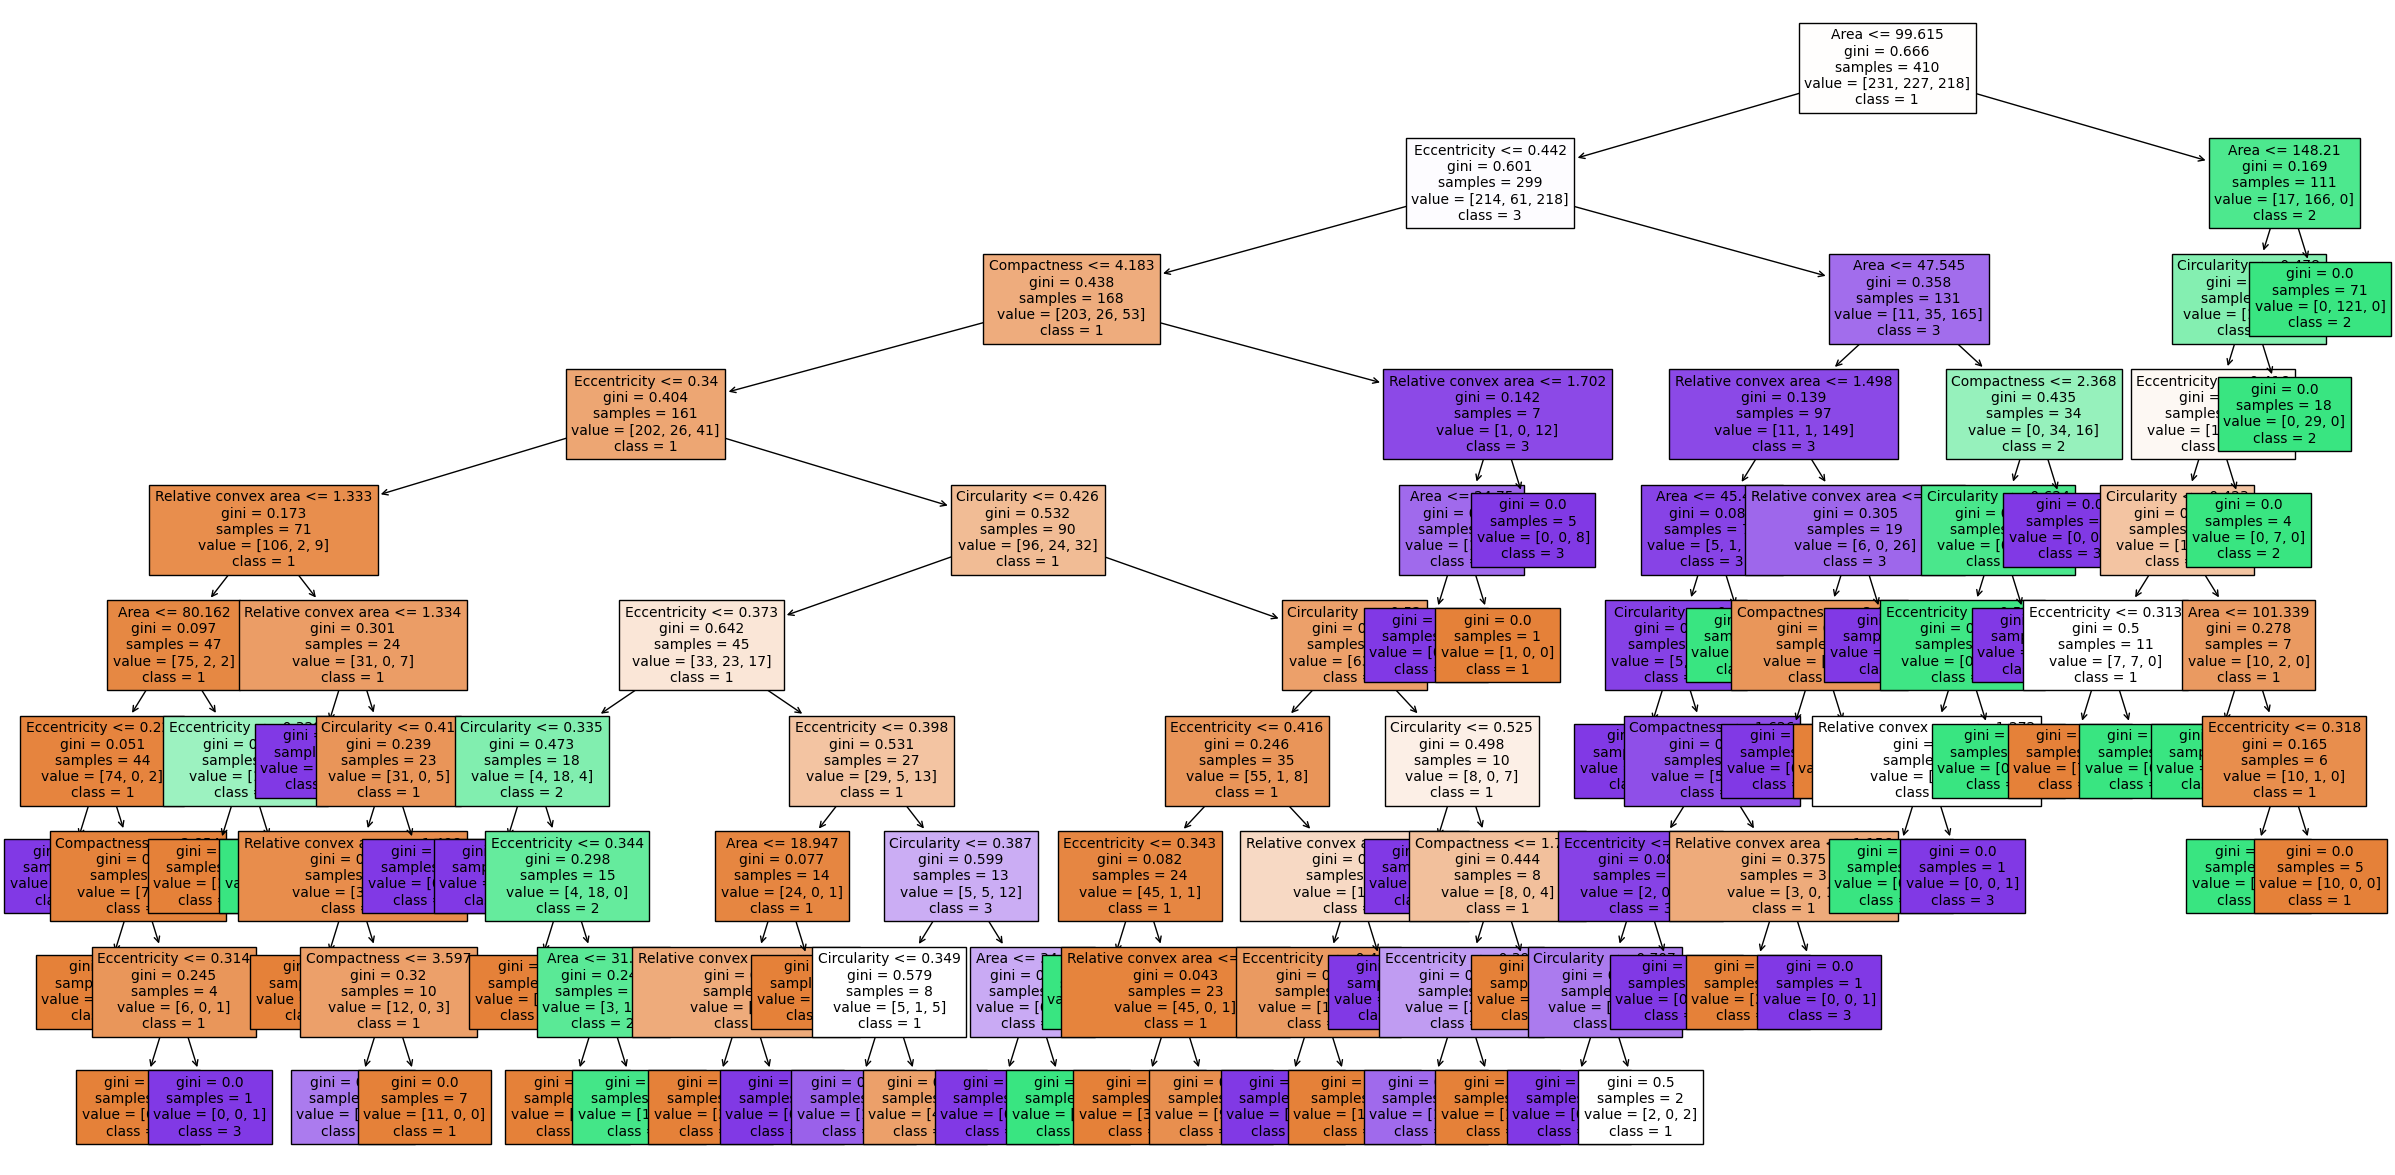

In [21]:
estimator = rf.estimators_[5]
fig,ax = plt.subplots(figsize=(30,15))
plot_tree(estimator,feature_names = data_filt.columns[:-1],class_names = ["1","2","3"],filled=True,fontsize=10)
plt.show()

# Testing

In [22]:
import pandas as pd
import cv2
import numpy as np

cols_data = ['Area', 'Roughness', 'Relative convex area', 'Circularity', 'Compactness', 'Eccentricity', 'Class']

img_file_path = r"C:\Users\JEEVANANTHAM\Downloads\bacilli_count\code\baci-count\data\train-test\Mannual_Microscope-2_set1\Images\20.jpg"
orig_img = cv2.imread(img_file_path)

if orig_img is None:
    raise FileNotFoundError(f"Image not found at path: {img_file_path}")

img_shape = (600, 800) 
img = orig_img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY_INV)
img_th_inv = 255 - img_th

img_seg = image_segmentation(img)

img_seg = cv2.resize(img_seg, (img_shape[1], img_shape[0]))

img_pp = image_postprocess(img_seg)

contours_filt = find_contours(img_pp)

data_test = pd.DataFrame(columns=cols_data)

img_cnt = np.zeros(img_shape, np.uint8)

for cnt in contours_filt:
    features = extract_features(cnt)
    cnt_centre, area, roughness, rel_conv_area, eccentricity, circularity, compactness, _ = features
    cls_lbl = None
    img_cnt = cv2.drawContours(img_cnt, [cnt], -1, 255, 3)

    df_temp = pd.DataFrame([{'Area': area, 'Roughness': roughness, 'Relative convex area': rel_conv_area,
                             'Circularity': circularity, 'Compactness': compactness, 'Eccentricity': eccentricity,
                             'Class': cls_lbl}])

    data_test = pd.concat([data_test, df_temp], ignore_index=True)

print(data_test.shape)
print(data_test.head())


(6, 7)
   Area  Roughness  Relative convex area  Circularity  Compactness  \
0  85.0   1.321061              1.964706     0.177390     5.637311   
1  54.5   1.082638              1.339450     0.517329     1.933005   
2  21.0   1.127876              2.047619     0.153553     6.512419   
3  12.5   1.014004              1.080000     0.472003     2.118632   
4  43.0   1.059381              1.569767     0.281676     3.550176   

   Eccentricity Class  
0      0.307938  None  
1      0.797340  None  
2      0.216350  None  
3      0.346551  None  
4      0.251591  None  


C:\Users\JEEVANANTHAM\AppData\Local\Temp\ipykernel_824\1114790778.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_test = pd.concat([data_test, df_temp], ignore_index=True)


In [31]:
import cv2
import numpy as np
import pandas as pd
import os

img_file_path = r"C:\Users\JEEVANANTHAM\Downloads\bacilli_count\code\baci-count\data\train-test\Mannual_Microscope-2_set1\Images\21.jpg"    

if not os.path.exists(img_file_path):
    raise FileNotFoundError(f"The file at path {img_file_path} does not exist.")

orig_img = cv2.imread(img_file_path)

if orig_img is None:
    raise ValueError(f"Failed to load image from path {img_file_path}. Ensure the file is an image and is not corrupted.")

orig_img_shape = orig_img.shape
img = orig_img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold(img_gray, 30, 255, cv2.THRESH_BINARY_INV)
img_th_inv = 255 - img_th

img_seg = image_segmentation(img)

img_shape = (600, 800) 
img_seg = cv2.resize(img_seg, (img_shape[1], img_shape[0]))

img_pp = image_postprocess(img_seg)

contours, _ = cv2.findContours(img_pp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_filt = find_contours(img_pp)

cols_data = ['Area', 'Relative convex area', 'Circularity', 'Compactness', 'Eccentricity', 'Class']
data_test = pd.DataFrame(columns=cols_data)

img_cnt = np.zeros(img_shape, np.uint8)

features_list = []

for cnt in contours_filt:
    features = extract_features(cnt)
    cnt_centre, area, roughness, rel_conv_area, eccentricity, circularity, compactness, eccentricity = features
    cls_lbl = None  
    img_cnt = cv2.drawContours(img_cnt, [cnt], -1, 255, 3)

    features_list.append({
        'Area': area, 
        'Roughness': roughness, 
        'Relative convex area': rel_conv_area, 
        'Circularity': circularity, 
        'Compactness': compactness, 
        'Eccentricity': eccentricity, 
        'Class': cls_lbl
    })

data_test = pd.DataFrame(features_list)

print(data_test.shape)
print(data_test.head())


(11, 7)
    Area  Roughness  Relative convex area  Circularity  Compactness  \
0   21.5   1.100998              1.488372     0.378197     2.644125   
1  193.5   1.115276              1.359173     0.339189     2.948211   
2    7.5   1.156453              2.666667     0.140504     7.117237   
3   10.5   1.296620              2.047619     0.215786     4.634214   
4   34.0   1.136572              1.676471     0.258851     3.863222   

   Eccentricity Class  
0      0.422359  None  
1      0.287867  None  
2      0.309102  None  
3      0.492865  None  
4      0.344420  None  


In [24]:
print(len(contours))
print(data_test.shape[0])
data_test.drop(["Roughness"],axis=1,inplace=True)

11
11


In [25]:
X_final_test = data_test.iloc[:,:-1]

y_final_test = rf.predict(X_final_test)

data_test["Class"] = y_final_test

print(y_final_test)

['1' '2' '3' '3' '1' '3' '3' '3' '3' '3' '3']


In [26]:
pd.set_option('display.max_rows',None)
data_test

,Area,Relative convex area,Circularity,Compactness,Eccentricity,Class
0,21.5,1.488372,0.378197,2.644125,0.422359,1
1,193.5,1.359173,0.339189,2.948211,0.287867,2
2,7.5,2.666667,0.140504,7.117237,0.309102,3
3,10.5,2.047619,0.215786,4.634214,0.492865,3
4,34.0,1.676471,0.258851,3.863222,0.344420,1
5,17.5,1.542857,0.220838,4.528200,0.147522,3
6,22.0,1.250000,0.546809,1.828791,0.648238,3
7,110.0,2.409091,0.165993,6.024336,0.459824,3
8,17.0,1.176471,0.552880,1.808711,0.423152,3
9,10.5,1.142857,0.396482,2.522181,0.406307,3


In [27]:
# Drawing bounding ellipses and rectangles across each contour of the test image where bounding ellipse indicates single bacillus,
# bounding rectangle indicates bacilli cluster and no bounding box indicates an artifact

img_bb = img_cnt.copy()  
for i in range(len(contours_filt)):
    cnt = contours_filt[i]
    (x_ell,y_ell),(ma,MA),angle = cv2.fitEllipse(cnt)
    x_rect,y_rect,w,h = cv2.boundingRect(cnt)
    if (data_test.iloc[i,-1]=='1'):
        #cv2.circle(img_bb,(int(x_ell),int(y_ell)),int(MA),255,3)
        cv2.ellipse(img_bb, (int(x_ell),int(y_ell)), (int(ma),int(MA)), int(angle), 0, 360, color=255, thickness=3) 
    elif (data_test.iloc[i,-1]=='2'):
        cv2.rectangle(img_bb, (x_rect, y_rect), (x_rect+w, y_rect+h), 255, 3)   

In [28]:
print(i)
print(len(contours_filt))
print(data_test.shape)

10
11
(11, 6)


In [29]:
# Detection and counting of single bacillus in all the bacilli clusters

num_sing_tb_list = []
for i in range(data_test.shape[0]):
    sing_tb_count = 0
    if (data_test["Class"][i]=="1"):
        sing_tb_count+=1
    elif (data_test["Class"][i]=="2"):
        cnt = contours_filt[i]
        sing_tb_count,defects = count_single_bacillus(cnt)
        sing_tb_count = max(1,sing_tb_count)
    num_sing_tb_list.append(sing_tb_count)
    
print(num_sing_tb_list)
print(f'Based on the concave points, no. of TB bacilli detected on given image are: {sum(num_sing_tb_list)}')

[1, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Based on the concave points, no. of TB bacilli detected on given image are: 6


Text(0.5, 0, 'Image with bounding boxes')

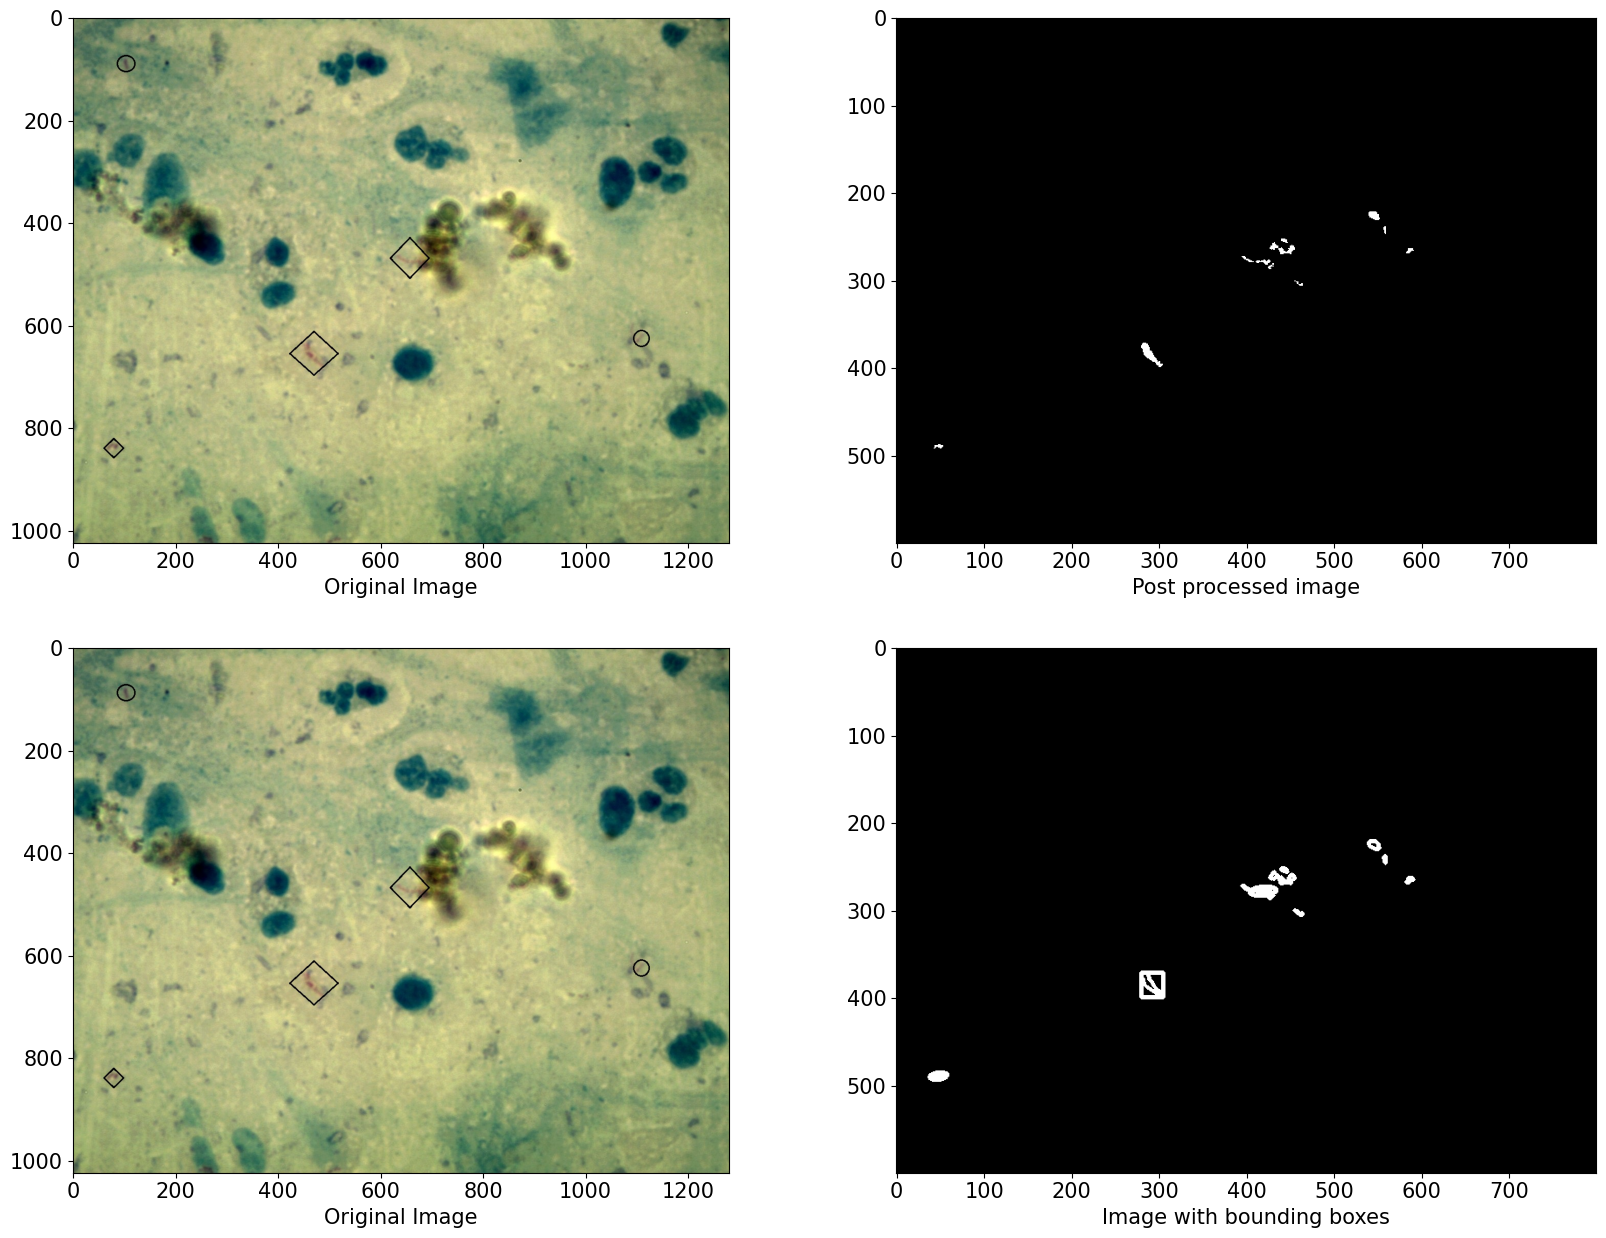

In [30]:
# Displaying original image, postprocessed image and image with contours and bounding boxes where the shape of bounding box
# across the contour indicates the type of bacilli i.e., single bacillus or bacilli cluster

matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(2,2,figsize=(20,15))
ax[0,0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
ax[0,0].set_xlabel("Original Image")
ax[0,1].imshow(img_pp, cmap='gray')
ax[0,1].set_xlabel("Post processed image")
ax[1,0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
ax[1,0].set_xlabel("Original Image")
ax[1,1].imshow(cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB))
ax[1,1].set_xlabel("Image with bounding boxes")